<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Функция-создания-признаков" data-toc-modified-id="Функция-создания-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функция создания признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Короткий-вывод-по-обучению" data-toc-modified-id="Короткий-вывод-по-обучению-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Короткий вывод по обучению</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Короткий-вывод-по-тестовой-части" data-toc-modified-id="Короткий-вывод-по-тестовой-части-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Короткий вывод по тестовой части</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer


from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)

In [2]:
try:
    data = pd.read_csv("d:/Temp/taxi.csv")
    
except FileNotFoundError:
    data = pd.read_csv("/datasets/taxi.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.sample(10)

,datetime,num_orders
19252,2018-07-12 16:40:00,19
25599,2018-08-25 18:30:00,29
15574,2018-06-17 03:40:00,15
8362,2018-04-28 01:40:00,20
14348,2018-06-08 15:20:00,19
7854,2018-04-24 13:00:00,5
9742,2018-05-07 15:40:00,9
6354,2018-04-14 03:00:00,10
13494,2018-06-02 17:00:00,17
19940,2018-07-17 11:20:00,18


In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

Ресемплинг на часовой интервал, с суммированием количества заказов в течение часа.

In [7]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

В обновлённом датафрейме имеем временной ряд количества заказов такси с марта по август 2018 года, разбитых по 1 часу, всего временных интервалов 4416.

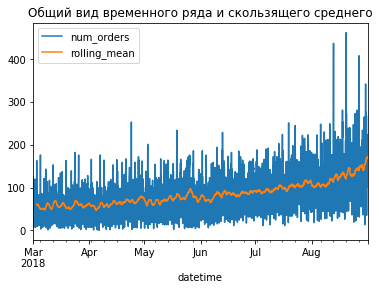

In [8]:
data['rolling_mean'] = data.rolling(48).mean()
data.plot()
plt.title('Общий вид временного ряда и скользящего среднего')
plt.show()

Виден тренд на увеличение спроса услуг такси.

Разобьем временной ряд на составляющие: тренд, сезонность и шум

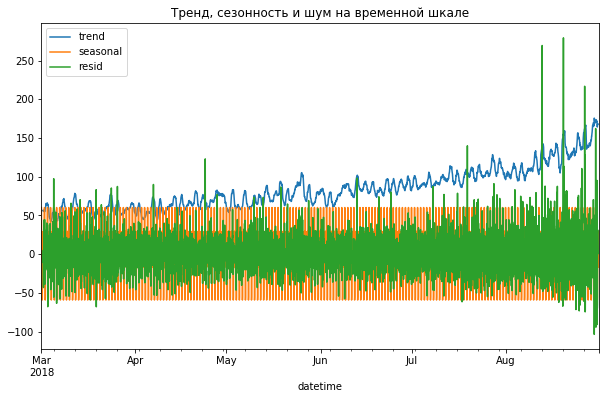

In [9]:
decomposed = seasonal_decompose(data['num_orders'])
data['trend'] = decomposed.trend
data['seasonal'] = decomposed.seasonal
data['resid'] = decomposed.resid

data[['trend', 'seasonal', 'resid']].plot(figsize=(10,6))
plt.title('Тренд, сезонность и шум на временной шкале')
plt.show()

Тренд, как видно, идёт на увеличение от марта к началу осени.

Сезонность так же присутствует.

Достаточно сильна шумовая составляющая.

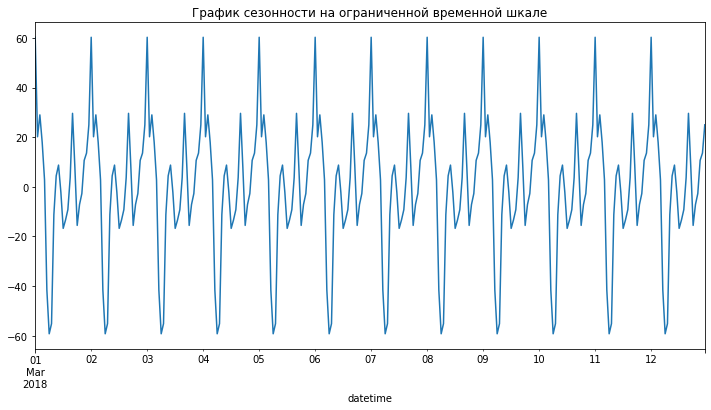

In [10]:
data['seasonal']['2018-03-01':'2018-03-12'].plot(figsize=(12,6))
plt.title('График сезонности на ограниченной временной шкале')
plt.show()

Из более чем недельного среза, видно что сезонная составляющая не меняется в зависимости от дня недели.

Посмотрим суточный график сезонности и определим пиковые нагрузки в аэпорту. Видимо в это время осуществляется вылет основных рейсов.

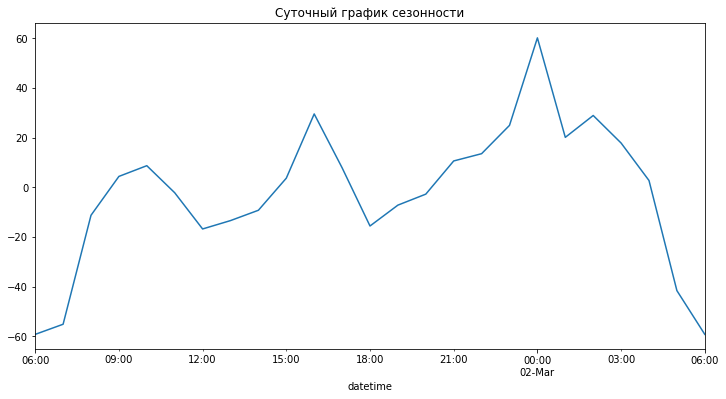

In [11]:
data['seasonal']['2018-03-01 06:00:00' :'2018-03-02 06:00:00'].plot(figsize=(12,6))
plt.title('Суточный график сезонности')
plt.show()

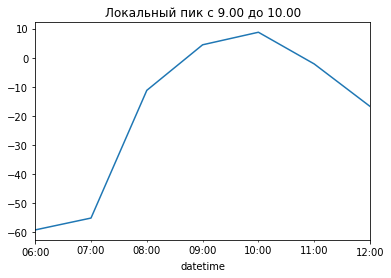

In [12]:
data['seasonal']['2018-03-01 06:00:00':'2018-03-01 12:00:00'].plot()
plt.title('Локальный пик с 9.00 до 10.00')
plt.show()

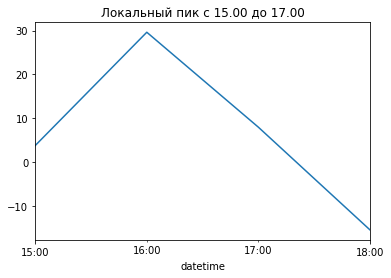

In [13]:
data['seasonal']['2018-03-01 15:00:00':'2018-03-01 18:00:00'].plot()
plt.title('Локальный пик с 15.00 до 17.00')
plt.show()

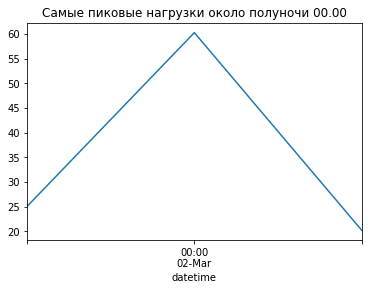

In [14]:
data['seasonal']['2018-03-01 23:00:00':'2018-03-02 01:00:00'].plot()
plt.title('Самые пиковые нагрузки около полуночи 00.00')
plt.show()

Вывод: 

 - Общий тренд идет на увеличение;
 - Сезонность проявляется каждые сутки;

Основной спрос на услуги такси с 7.00 по 4.00 следущего дня.
Утренние часы: около 6.00 самый низкий спрос. 

 - 1 локальный максимум - утреннее время с 7 до 10;
 - 2 локальный максимум - около 16.00;
 - 3 локальный максимум - 00.00.

Время пиковых нагрузок связано с высоким количеством прилетов и вылетов в данные часы, максимальная нагрузка в 00.00, возможно так же обусловлена прекращением работы общественного транспорта (период с 22.00 до 03.00 указывает на увеличение количества заказов, даже более чем в локальном максимуме около 16.00).

## Обучение

Для обучения, максимальный шаг свига выберем равный 168 часам (24 часа в сутках * 7 дней в неделю, сдвиг на неделю), в процессе обучения в подборе сдвига и выбора размера окна интервала я руководствовался именно этими значениями max_lag - 168, rolling_mean_size - 24, по мере обучения я сократил окна для подбора этих параметров до минимума (для каждой модели разные занчения).

In [15]:
MSE = make_scorer(mean_squared_error)


# восстановим дата фрейм для дальнейшего обучения
data = pd.DataFrame(data['num_orders'])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Функция создания признаков

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

### LinearRegression

In [17]:
RSME_best = 999

make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
        
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
        
lin_reg = LinearRegression(n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=8)
scores = cross_val_score(lin_reg, features_train, target_train, scoring=MSE, cv=tscv)

if RSME_best > scores.mean() ** 0.5:
    RSME_best = scores.mean() ** 0.5      
        
print("RMSE обучающей выборки:", scores.mean() ** 0.5)

RMSE обучающей выборки: 31.738876419539274


In [18]:
# создание сводной таблицы с результатами

pivot = pd.DataFrame(columns=['RMSE_train', 'RMSE_test'],
                     index=['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor'])

### DecisionTreeRegressor

In [19]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
       
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

parametrs = {'max_depth': range (1,13,2)}

tscv = TimeSeriesSplit(n_splits=8)

grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=12345),
                       param_grid=parametrs,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=0)
grid_tree.fit(features_train, target_train)

scores = cross_val_score(grid_tree, features_train, target_train, scoring=MSE, cv=tscv)

RSME_best = scores.mean() ** 0.5
        
print("RMSE обучающей выборки:", RSME_best)

pivot.loc['DecisionTreeRegressor', 'RMSE_train'] = RSME_best

RMSE обучающей выборки: 28.113861930870936


### RandomForestRegressor

In [20]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
       
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

parametrs = { 'max_depth': range (1, 13, 2),
             'n_estimators': range (10, 51, 10)
            }
        
grid_forest = GridSearchCV(RandomForestRegressor(random_state=12345),
                       param_grid=parametrs,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=0)
grid_forest.fit(features_train, target_train)

scores = cross_val_score(grid_forest, features_train, target_train, scoring=MSE, cv=tscv)

RSME_best = scores.mean() ** 0.5
        
print("RMSE обучающей выборки:", RSME_best)

pivot.loc['RandomForestRegressor', 'RMSE_train'] = RSME_best

RMSE обучающей выборки: 25.126478293205228


### CatBoostRegressor

In [21]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
       
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

parametrs = {'iterations': range (50, 61, 10)}

grid_catboost = GridSearchCV(CatBoostRegressor(loss_function = 'RMSE', random_state=12345, verbose=0),
                     param_grid=parametrs,
                     scoring='neg_mean_squared_error',
                     n_jobs=-1,
                     cv=tscv,
                     verbose=0)
grid_catboost.fit(features_train, target_train)

scores = cross_val_score(grid_catboost, features_train, target_train, scoring=MSE, cv=tscv)
RSME_best = scores.mean() ** 0.5
        
pivot.loc['CatBoostRegressor', 'RMSE_train'] = RSME_best

In [22]:
print("RMSE обучающей выборки:", RSME_best)

RMSE обучающей выборки: 29.06996830145209


### Короткий вывод по обучению

В результате обучения моделей, подобраны гиперпараметры моделей, шаг свдвига, размер окна скользящего среднего, при котором достигнуты минимальные значения RMSE. Лучшее значение показала LinearRegression, на втором месте RandomForestRegressor и CatBoostRegressor, худшее значение метрики показала модель DecisionTreeRegressor. Посмотрим как поведут себя модели на тестовых выборках.

Данные для визуального анализа собраны в сводную таблицу.

## Тестирование

### LinearRegression

In [23]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [24]:
scores = cross_val_score(lin_reg, features_test, target_test, scoring=MSE, cv=tscv)
print('RMSE обучающей выборки:', scores.mean() ** 0.5)
pivot.loc['LinearRegression', 'RMSE_test'] = scores.mean() ** 0.5

RMSE обучающей выборки: 53.621448451256605


### DecisionTreeRegressor

In [25]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [26]:
scores = cross_val_score(grid_tree, features_test, target_test, scoring=MSE, cv=tscv)
print('RMSE обучающей выборки:', scores.mean() ** 0.5)
pivot.loc['DecisionTreeRegressor', 'RMSE_test'] = scores.mean() ** 0.5

RMSE обучающей выборки: 49.962310225558184


### RandomForestRegressor

In [27]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
target_test_forest = target_test

predict_forest = grid_forest.predict(features_test)

In [28]:
scores = cross_val_score(grid_forest, features_test, target_test, scoring=MSE, cv=tscv)
print('RMSE обучающей выборки:', scores.mean() ** 0.5)
pivot.loc['RandomForestRegressor', 'RMSE_test'] = scores.mean() ** 0.5

RMSE обучающей выборки: 44.87879246539856


### CatBoostRegressor

In [29]:
make_features(data, 2, 24)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [30]:
scores = cross_val_score(grid_catboost, features_test, target_test, scoring=MSE, cv=tscv)
scores.mean() ** 0.5

50.31805044216507

In [31]:
pivot.loc['CatBoostRegressor', 'RMSE_test'] = scores.mean() ** 0.5
print('RMSE обучающей выборки:', scores.mean() ** 0.5)

RMSE обучающей выборки: 50.31805044216507


In [32]:
pivot

,RMSE_train,RMSE_test
LinearRegression,NaN,53.6214
DecisionTreeRegressor,28.1139,49.9623
RandomForestRegressor,25.1265,44.8788
CatBoostRegressor,29.07,50.3181


### Короткий вывод по тестовой части

Проверка обученных моделей на тестовых выборках показала, что наш лидер в обучении LinearRegression - явно переобучился.

Лучший результат на тестовой выборке показала модель RandomForestRegressor, с небольшим отставанием CatBoostRegressor.

Сравним показатели реального и предсказанного спроса

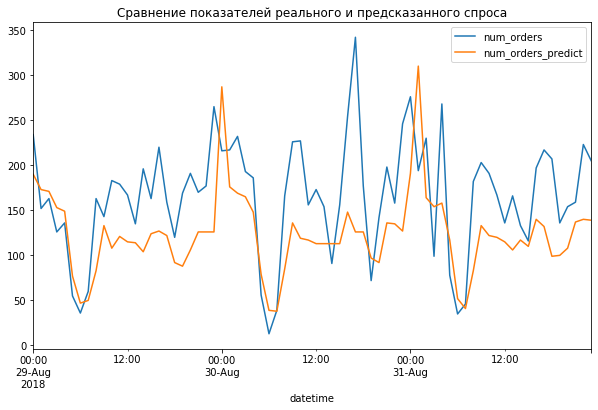

In [33]:
errors = pd.DataFrame(target_test_forest)

errors['num_orders_predict'] = predict_forest.round().astype('int')
errors['2018-08-29':'2018-08-31'].plot(figsize=(10,6))
plt.title('Сравнение показателей реального и предсказанного спроса')
plt.show()

<div style="background: #bda4de; padding: 5px; border: 1px solid black; border-radius: 5px;">
<font color='black'> 
    <b><u>Вывод</u></b>
     
</font>
<font color='black'><br>
    
<u>Основные не попадалки</u>

Самый аномальный период, где модель сильно не совпала с реальными результатами.
    
29.08 модель следует за графиком реальных значений, но уже 30 августа случился непредвиденный всплеск, который модель не отработала, это обусловлено единичным случаем нетипичного события. Возможно из за сложных метеоусловий задержали много рейсов, просадки спроса до и после экстремума.